## Subtask 2 - Polarization type classification

Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

## Imports

In [1]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [2]:
import random
import numpy as np
import torch

SEED = 42

# Python
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch (CPU)
torch.manual_seed(SEED)

# PyTorch (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you have multiple GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

## Data Import

In [5]:
# Load the training and validation data for subtask 1

train = pd.read_csv('subtask2/train/swa.csv')
train_plus = pd.read_csv('swa_backtranslated.csv')
# train_plus = pd.read_csv('eng_BT_full.csv')

train.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,swa_53de6a7a4d0123b5755da79d8d97a82f,uwizi rt kenyan rao akishinda nitachinja kuku ...,0,1,0,0,0
1,swa_ee2533cb334df97236ea2bcfda0d6823,wakikuyu ndio wako na manyumba za kukodeshwa t...,0,1,0,0,0
2,swa_1dd81b5985840a55b1ab292aa65d11a8,wakikuyu ni wezi power hungry and this time we...,0,1,0,0,0
3,swa_18589adc3945e20c5e5c61e10245fad1,wakikuyu sijui shida yenu ni nini kuogopa rail...,0,1,0,0,0
4,swa_aee76fc4cd1c6c6c09e19ba5ddd3901a,wakikuyu walisogwa hwakuumbwa,0,1,0,0,0


In [6]:
train_plus.head()

,id,text,polarization,back_translated
0,swa_53de6a7a4d0123b5755da79d8d97a82f,uwizi rt kenyan rao akishinda nitachinja kuku ...,1,Uhuru rt Kenya rao anashinda mimi kuua kuku CN...
1,swa_ee2533cb334df97236ea2bcfda0d6823,wakikuyu ndio wako na manyumba za kukodeshwa t...,1,Tini ni yako na nyumba ni kukodishwa.
2,swa_1dd81b5985840a55b1ab292aa65d11a8,wakikuyu ni wezi power hungry and this time we...,1,Wikuyu ni wezi njaa nguvu na wakati huu tumeka...
3,swa_18589adc3945e20c5e5c61e10245fad1,wakikuyu sijui shida yenu ni nini kuogopa rail...,1,WIKIKUYU Sijui tatizo lako ni nini hofu Railsk...
4,swa_aee76fc4cd1c6c6c09e19ba5ddd3901a,wakikuyu walisogwa hwakuumbwa,1,Na tini zilifunuliwa na kuumbwa


In [7]:
train.shape

(6991, 7)

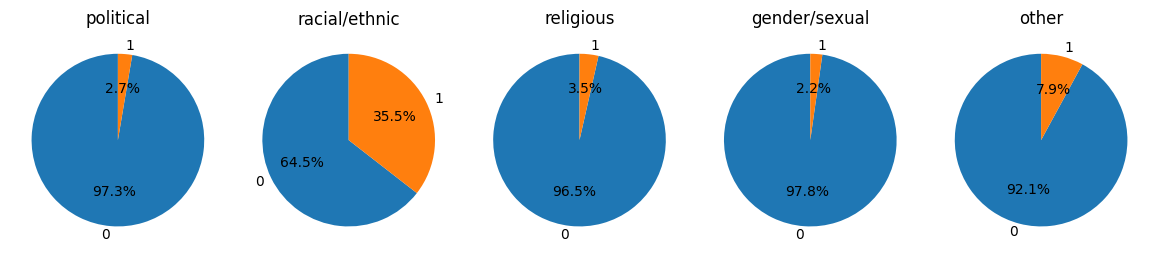

In [8]:
import matplotlib.pyplot as plt

## Only relevant label
labels = train.columns[2:]
n = len(labels)

# A4 landscape size (inches)
fig, axes = plt.subplots(1, n, figsize=(11.69, 2.8))

# If only one label, axes is not iterable
if n == 1:
    axes = [axes]

for idx, label in enumerate(labels):
    counts = train[label].value_counts().sort_index()

    axes[idx].pie(
        counts,
        labels=["0", "1"],
        autopct="%1.1f%%",
        startangle=90
    )
    axes[idx].set_title(label)

plt.tight_layout()
plt.savefig("repartition.pdf")
plt.show()

# Dataset
-  Create a pytorch class for handling data
-  Wrapping the raw texts and labels into a format that Huggingface’s Trainer can use for training and evaluation

In [9]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

Now, we'll tokenize the text data and create the datasets using `bert-base-uncased` as the tokenizer.

## Base-line from here

In [10]:
# Load the tokenizer
MODEL_NAME = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## Data processing

In [11]:
# Add the labels to the translated
# Keep only what you need
train_plus = train_plus.drop(columns=["text", "polarization"])

# Replace text with back-translated text
train_plus['text'] = train_plus['back_translated']

# Add labels ONCE
label_cols = ['political','racial/ethnic','religious','gender/sexual','other']
train_plus[label_cols] = train[label_cols].values


# Sample some from the translation
sample_size = 1000
back_tranlated_sampled = train_plus.sample(n=sample_size)

train_combined = pd.concat([train, back_tranlated_sampled], axis=0)
val_df = train_plus.sample(n=300, random_state=42)

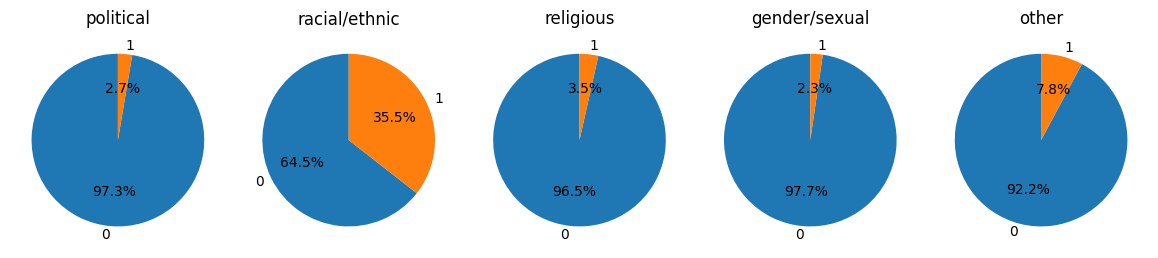

In [12]:
# A4 landscape size (inches)
fig, axes = plt.subplots(1, n, figsize=(11.69, 2.8))

# If only one label, axes is not iterable
if n == 1:
    axes = [axes]

for idx, label in enumerate(labels):
    counts = train_combined[label].value_counts().sort_index()

    axes[idx].pie(
        counts,
        labels=["0", "1"],
        autopct="%1.1f%%",
        startangle=90
    )
    axes[idx].set_title(label)

plt.tight_layout()
plt.show()

In [13]:
# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(
    train['text'].tolist(),
    train[['political','racial/ethnic','religious','gender/sexual','other']].values.tolist(),
    tokenizer
)
val = PolarizationDataset(
    train['text'].tolist()[-300:],
    train[['political','racial/ethnic','religious','gender/sexual','other']].values.tolist()[-300:],
    tokenizer
)

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=5,
    problem_type="multi_label_classification",
    # local_files_only=True # Only if the model is downloaded locally
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining training arugments

In [15]:
# Load into the GPU
model.to('cuda')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [16]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=4,
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    probs = torch.sigmoid(torch.from_numpy(p.predictions))

    thresholds = torch.tensor([0.3, 0.25, 0.05, 0.05, 0.05])

    preds = (probs > thresholds).int()

    return {
        "f1_macro": f1_score(
            p.label_ids,
            preds.numpy(),
            average="macro"
        )
    }


In [17]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.221700,0.277710,0.197477
2,0.186600,0.264722,0.209742
3,0.172800,0.246415,0.214490
4,0.161000,0.236585,0.216020


/home/supercell/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/supercell/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Macro F1 score on validation set for Subtask 3: 0.2160200364298725


In [19]:
# Load the dev data (only has 'id' and 'text' columns)
dev = pd.read_csv('subtask2/dev/swa.csv')

# Create a dataset for dev (without labels)
class PolarizationDatasetTest(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False,
                                   max_length=self.max_length, return_tensors='pt')
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item


# Build test dataset
test_dataset = PolarizationDatasetTest(dev['text'].tolist(), tokenizer)

# Run prediction
pred_output = trainer.predict(test_dataset)

# Get logits → probabilities
probs = torch.sigmoid(
    torch.from_numpy(pred_output.predictions)
).numpy()

# Per-label thresholds (must match number of labels)
thresholds = np.array([0.005, 0.3, 0.4, 0.005, 0.005])

# Apply thresholds (vectorized)
preds = (probs > thresholds).astype(int)

# Create submission dataframe
submission = pd.DataFrame({
    'id': dev['id'],
    'political': preds[:, 0],
    'racial/ethnic': preds[:, 1],
    'religious': preds[:, 2],
    'gender/sexual': preds[:, 3],
    'other': preds[:, 4]
})

# Save to CSV
submission.to_csv('pred_swa.csv', index=False)

print("Predictions saved to pred_swa.csv")
print(submission.head())

Predictions saved to pred_swa.csv
                                     id  political  racial/ethnic  religious  \
0  swa_a5748df181277341143f7da4175add4a          1              1          0   
1  swa_2df0d42f9b49ea2e4fb006b2e6604e6d          1              1          0   
2  swa_3718757514005767302b7220b08e409d          1              1          0   
3  swa_9fa3337a35cce723d60c06056d422330          1              1          0   
4  swa_5c39ac8ef70345e9e3c21a47f8769bc0          1              1          0   

   gender/sexual  other  
0              1      1  
1              1      1  
2              1      1  
3              1      1  
4              1      1  


In [ ]:
# After training
del model
torch.cuda.empty_cache()
import gc
gc.collect()

In [ ]:
pred_output.predictions.max(axis=0)